## nInputs analysis
Analyze output from the nInputs experiment run using the `nInputs.py` and `nInputs_WB.py` withing the `scripts` directory. These scripts run simulations of Hodgkin-Huxley and Wang-Buzsaki cells within the event-based simulation framework using different numbers of input history. These simulations are then compared to the standard conductance-based simulation of these models.

We first compare raster diagrams of these simulations. Then, we compare the observed inter-spike-interval distributions. And finally measure the Victor Purpura and van Rossum distances between the observed spike trains of these simulations. 

In [ ]:
import sys
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
sys.path.insert(1, "../utils/")
import HH, WB, Stimuli

from neuron import h
h.load_file("stdrun.hoc")
from neuron.units import mV, ms

from sklearn.neighbors import KernelDensity

# used for spike train comparison
from quantities import ms, s, Hz
import elephant.statistics as estats
import elephant
import neo
from elephant.spike_train_dissimilarity import victor_purpura_distance
from elephant.spike_train_dissimilarity import van_rossum_distance

## load data

In [2]:
def read_events_from_file(fname):
    with open(fname, 'r') as f:
        events = f.readlines()
        events = [float(event.strip()) for event in events]
        return events
    
def remove_duplicate_spikes(events):
    events = list(set(events))
    events.sort()
    return events

ns = list(range(3,51)) # these are the ns we are considering for the n in the nInputs experiment. 

output_dir_os = '../data/nInputs/'
output_dir_nos = '../data/nInputs_no_ospike/'
output_dir_wb_nos = '../data/nInputs_WB/'
output_dir_wb_os = '../data/nInputs_ospike_WB/'
mccleary_dir = '../data/nInputs_mccleary/' # this is data run on McCleary HPC
figures_dir = '../figures/'

In [3]:
# _os : refers to the event-input embedding that includes the last output spike event
# _nos : refers to the event-input embedding that does not include the last output spike event
nInputs_results = {
    'base_os':{},
    'lw_os':{},
    'lt_os':{},
    'lwlt_os':{},
    'burst_os':{},
    'wb_os':{},
    'base_nos':{},
    'lw_nos':{},
    'lt_nos':{},
    'lwlt_nos':{},
    'burst_nos':{},
    'wb_nos':{}
}

nInputs_stimuli = {
    'base_os':{'e':{},'i':{}},
    'lw_os':{'e':{},'i':{}},
    'lt_os':{'e':{},'i':{}},
    'lwlt_os':{'e':{},'i':{}},
    'burst_os':{'e':{},'i':{}},
    'wb_os':{'e':{},'i':{}},
    'base_nos':{'e':{},'i':{}},
    'lw_nos':{'e':{},'i':{}},
    'lt_nos':{'e':{},'i':{}},
    'lwlt_nos':{'e':{},'i':{}},
    'burst_nos':{'e':{},'i':{}},
    'wb_nos':{'e':{},'i':{}}
}

In [4]:
# HH with output spike
print('loading HH with ospike')
for file in os.listdir(output_dir_os):
    # output spikes file
    if 'istims' not in file and 'estims' not in file:
        model_type = file.split('_')[0]
        n = int(file.split('_')[1])
        nInputs_results[model_type+'_os'][n] = remove_duplicate_spikes(read_events_from_file(output_dir_os+file))
    elif 'istims' in file:
        model_type = file.split('_')[0]
        n = int(file.split('_')[1])
        nInputs_stimuli[model_type+'_os']['i'][n] = read_events_from_file(output_dir_os+file)
    elif 'estims' in file:
        model_type = file.split('_')[0]
        n = int(file.split('_')[1])
        nInputs_stimuli[model_type+'_os']['e'][n] = read_events_from_file(output_dir_os+file)

# HH without output spike
print('loading HH without ospike')
for file in os.listdir(output_dir_nos):
    # output spikes file
    if 'istims' not in file and 'estims' not in file:
        model_type = file.split('_')[0]
        n = int(file.split('_')[1])
        nInputs_results[model_type+'_nos'][n] = remove_duplicate_spikes(read_events_from_file(output_dir_nos+file))
    elif 'istims' in file:
        model_type = file.split('_')[0]
        n = int(file.split('_')[1])
        nInputs_stimuli[model_type+'_nos']['i'][n] = read_events_from_file(output_dir_nos+file)
    elif 'estims' in file:
        model_type = file.split('_')[0]
        n = int(file.split('_')[1])
        nInputs_stimuli[model_type+'_nos']['e'][n] = read_events_from_file(output_dir_nos+file)

# WB with output spike
print('loading WB with ospike')
for file in os.listdir(output_dir_wb_os):
    # output spikes file
    if 'istims' not in file and 'estims' not in file:
        model_type = file.split('_')[0]
        n = int(file.split('_')[1])
        nInputs_results[model_type+'_os'][n] = remove_duplicate_spikes(read_events_from_file(output_dir_wb_os+file))
    elif 'istims' in file:
        model_type = file.split('_')[0]
        n = int(file.split('_')[1])
        nInputs_stimuli[model_type+'_os']['i'][n] = read_events_from_file(output_dir_wb_os+file)
    elif 'estims' in file:
        model_type = file.split('_')[0]
        n = int(file.split('_')[1])
        nInputs_stimuli[model_type+'_os']['e'][n] = read_events_from_file(output_dir_wb_os+file)

# WB without output spike
print('loading WB without ospike')
for file in os.listdir(output_dir_wb_nos):
    # output spikes file
    if 'istims' not in file and 'estims' not in file:
        model_type = file.split('_')[0]
        n = int(file.split('_')[1])
        nInputs_results[model_type+'_nos'][n] = remove_duplicate_spikes(
            read_events_from_file(output_dir_wb_nos+file))
    elif 'istims' in file:
        model_type = file.split('_')[0]
        n = int(file.split('_')[1])
        nInputs_stimuli[model_type+'_nos']['i'][n] = read_events_from_file(output_dir_wb_nos+file)
    elif 'estims' in file:
        model_type = file.split('_')[0]
        n = int(file.split('_')[1])
        nInputs_stimuli[model_type+'_nos']['e'][n] = read_events_from_file(output_dir_wb_nos+file)

# McCleary data (n > 30)
print('loading McCleary data')
for file in os.listdir(mccleary_dir):
    # output spikes file
    if 'nos' in file:
        if 'istims' not in file and 'estims' not in file:
            model_type = file.split('_')[0]
            n = int(file.split('_')[1])
            nInputs_results[model_type+'_nos'][n] = remove_duplicate_spikes(
                read_events_from_file(mccleary_dir+file))
        elif 'istims' in file:
            model_type = file.split('_')[0]
            n = int(file.split('_')[1])
            nInputs_stimuli[model_type+'_nos']['i'][n] = read_events_from_file(mccleary_dir+file)
        elif 'estims' in file:
            model_type = file.split('_')[0]
            n = int(file.split('_')[1])
            nInputs_stimuli[model_type+'_nos']['e'][n] = read_events_from_file(mccleary_dir+file)
    else:
        if 'istims' not in file and 'estims' not in file:
            model_type = file.split('_')[0]
            n = int(file.split('_')[1])
            nInputs_results[model_type+'_os'][n] = remove_duplicate_spikes(
                read_events_from_file(mccleary_dir+file))
        elif 'istims' in file:
            model_type = file.split('_')[0]
            n = int(file.split('_')[1])
            nInputs_stimuli[model_type+'_os']['i'][n] = read_events_from_file(mccleary_dir+file)
        elif 'estims' in file:
            model_type = file.split('_')[0]
            n = int(file.split('_')[1])
            nInputs_stimuli[model_type+'_os']['e'][n] = read_events_from_file(mccleary_dir+file)

loading HH with ospike
loading HH without ospike
loading WB with ospike
loading WB without ospike
loading McCleary data


In [5]:
# show which n for which category we have, make sure all the data is here
for stim_type in nInputs_results:
    print(stim_type)
    print(sorted(nInputs_results[stim_type].keys()))
    print()

base_os
[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50]

lw_os
[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50]

lt_os
[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50]

lwlt_os
[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50]

burst_os
[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50]

wb_os
[2, 3, 

## compare to conductance-based simulation
This involves running the conductance-based simulations here.

In [6]:
# the stimuli are the same for every model_type, so only need to load once
etimes = nInputs_stimuli['base_os']['e'][30] # the base_os and 30 here is arbitrary, they are all the same
itimes = nInputs_stimuli['base_os']['i'][30] 

In [7]:
# generate models

# these must be run at 6.3C
conductance_models = {
    'base':HH.HH(),
    'lw':HH.HH(),
    'lt':HH.HH(),
    'lwlt':HH.HH(),
    'burst':HH.HH(),
}

# this must be run at 37C
conductance_models_wb = {
    'wb':WB.WB(),
}

duration = 100000

median_histories = {
    'base':{'v': -65.4783123433392,'m': 0.05010827491974185,'n': 0.3322977316054023,'h': 0.5662937503578902},
    'lw':{'v': -65.05216588491975,'m': 0.053287759884193084,'n': 0.33057516280125593,'h': 0.5677966607940762},
    'lt':{'v': -65.33224022733997,'m': 0.05173948745008535,'n': 0.3382151028430245,'h': 0.5478173816286583},
    'burst':{'v': -60.34919267323213,'m': 0.0930119959051144,'n': 0.4159070018061663,'h': 0.3913119513056261},
    'lwlt':{'v': -64.26695731748968,'m': 0.058854810796640095,'n': 0.35634157654504517,'h': 0.511360555565485},
    'wb':{'v': -62.63896424137329, 'm': 0.10259466539537955, 'h': 0.7298860063700434},
 }

stim_params = Stimuli.ExperimentalStimParams()

# set up HH models
for model_type in conductance_models:
    # provide stimuli
    estims = stim_params.stim_scaffold[model_type]['ex']
    estims.stim_times = etimes
    istims = stim_params.stim_scaffold[model_type]['in']
    istims.stim_times = itimes
    conductance_models[model_type].add_custom_stimulus(estims)
    conductance_models[model_type].add_custom_stimulus(istims)

    # initialize with median history
    history = median_histories[model_type]
    
    conductance_models[model_type].sim_init(
        v0 = history['v'],
        m0 = history['m'],
        h0 = history['h'],
        n0 = history['n']
    )

# set up WB models
model_type = 'wb'
estims = stim_params.stim_scaffold[model_type]['ex']
estims.stim_times = etimes
istims = stim_params.stim_scaffold[model_type]['in']
istims.stim_times = itimes
conductance_models_wb[model_type].add_custom_stimulus(estims)
conductance_models_wb[model_type].add_custom_stimulus(istims)

history = median_histories['wb']
conductance_models_wb['wb'].sim_init(
    v0 = history['v'],
    m0 = history['m'],
    h0 = history['h'],
)
        
# run models and record spikes
conductance_model_spikes = {
    'base':None,
    'lw':None,
    'lt':None,
    'lwlt':None,
    'burst':None,
    'wb':None
}

# initialize all models
fihs = [h.FInitializeHandler(conductance_models[model_type].do_sim_init) for model_type in conductance_models]

# Run this at 6.3C
h.celsius = 6.3
conductance_models['base'].run_simulation(duration)
# commit spike times to record
for model_type in conductance_models:
    conductance_model_spikes[model_type] = list(conductance_models[model_type].spike_times)

# Run these at 37C
h.celsius = 37
conductance_models_wb['wb'].run_simulation(duration)
# commit spike times to record
conductance_model_spikes['wb'] = list(conductance_models_wb['wb'].spike_times)

## Compare Rasters

In [8]:
def compare_rasters(eb_spikes, cond_spikes, n_to_plot=[50,30, 20, 15, 10, 5, 4,3,2]):
    xlim = (0,1000)
    fig, axes = plt.subplots(3+len(n_to_plot), 1, figsize=(10, 3), sharex=True, sharey=True)
    
    axes[0].vlines(etimes, 0, 1, color='red')
    axes[1].vlines(itimes, 0, 1, color='blue')
    
    
    axes[2].vlines(cond_spikes, 0, 1, color='green')
    
    for i, n in enumerate(n_to_plot):
        axes[3+i].vlines(eb_spikes[n], 0, 1, color='black')
        axes[3+i].set_ylabel(n)

    axes[0].set_yticks([])
    axes[-1].set_xlabel('time (ms)')

    axes[0].set_ylabel('e stims')
    axes[1].set_ylabel('i stims')
    axes[2].set_ylabel('hh')

    axes[-1].set_xlim(xlim)
    plt.show()

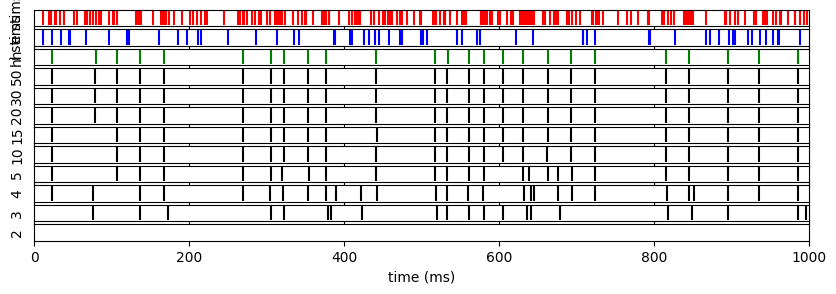

In [9]:
compare_rasters(nInputs_results['base_os'], conductance_model_spikes['base'])

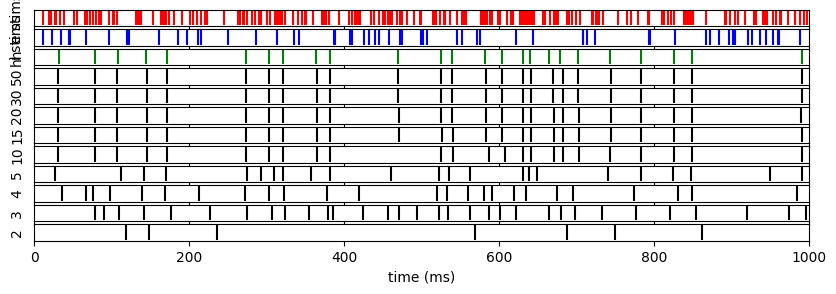

In [10]:
compare_rasters(nInputs_results['wb_os'], conductance_model_spikes['wb'])

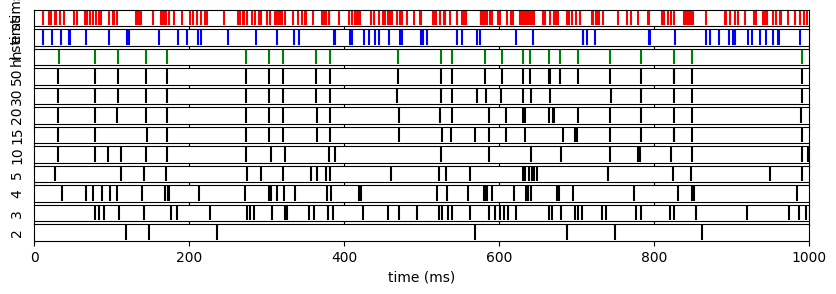

In [11]:
compare_rasters(nInputs_results['wb_nos'], conductance_model_spikes['wb'])

## Compare ISIs

In [12]:
def compare_ISIs(eb_spikes, cond_spikes, n_to_plot = [2,3,4,5,20,50], bins = np.arange(0,100,2), title=None):
    fig, ax = plt.subplots(figsize=(10,6))

    colors = ['gold','orange','darkorange','orangered','red','darkred','brown']
    alpha = 0.6

    for i, n in enumerate(n_to_plot):
        train = eb_spikes[n]
        ax.hist(([train[i] - train[i-1] for i in range(1,len(train))]), 
                 histtype='step', bins=bins,linewidth=3.0, alpha=alpha, color=colors[i])
        ax.hist(([train[i] - train[i-1] for i in range(1,len(train))]), 
                 bins=bins, alpha=0.1, color=colors[i])
    ax.hist(([cond_spikes[i] - cond_spikes[i-1] for i in range(1,len(cond_spikes))]), 
                 histtype='step', bins=bins,linewidth=3.0, alpha=alpha, color='black')

    ax.legend([f'{n} inputs' for n in n_to_plot] + ['hh spikes'], fontsize=14)
    ax.set_xlabel('time (ms)', fontsize=16)
    xticks = range(0,101,20)
    ax.set_xticks(xticks)
    ax.set_yticks([])
    ax.set_xticklabels(xticks, fontsize=16)
    ax.set_xlim(0,100)

    #ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    
    if title:
        ax.set_title(title, fontsize=16)
    plt.show()

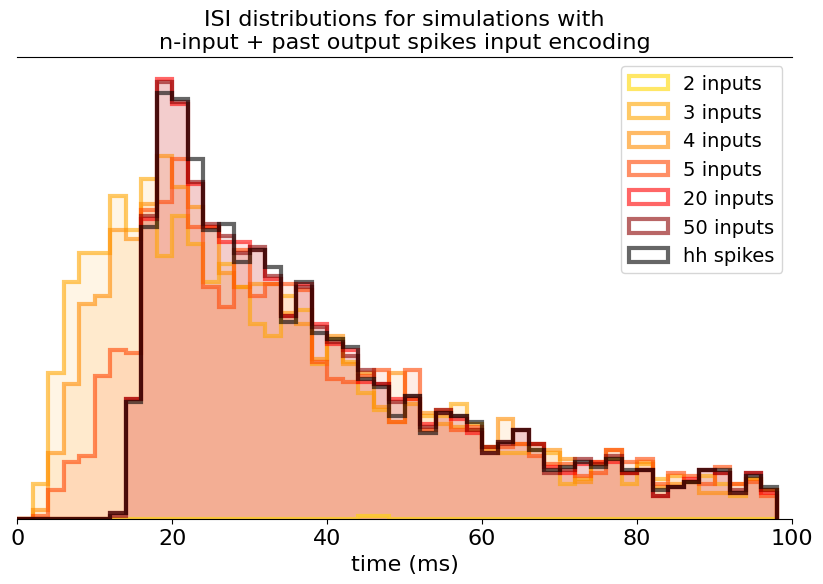

In [13]:
compare_ISIs(
    nInputs_results['base_os'], conductance_model_spikes['base'],
    title='ISI distributions for simulations with\nn-input + past output spikes input encoding')

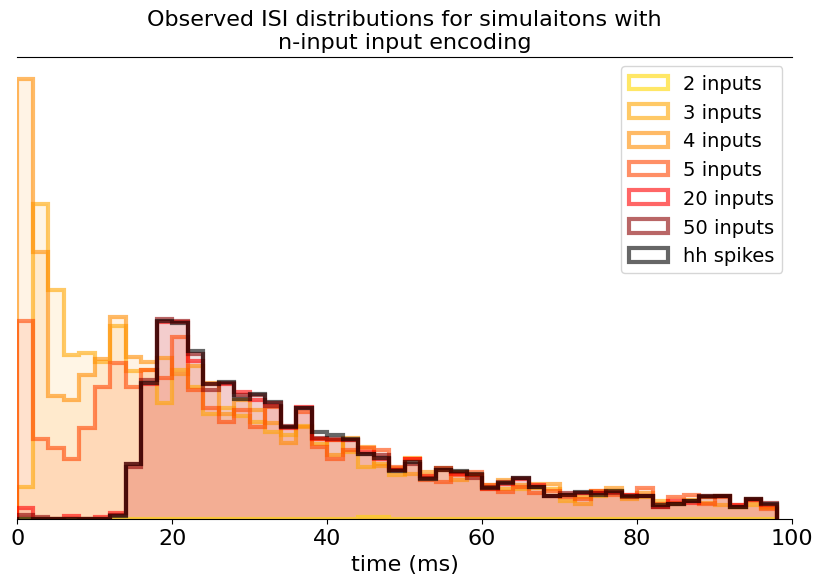

In [14]:
compare_ISIs(
    nInputs_results['base_nos'], conductance_model_spikes['base'],
    title='Observed ISI distributions for simulaitons with\nn-input input encoding'
)

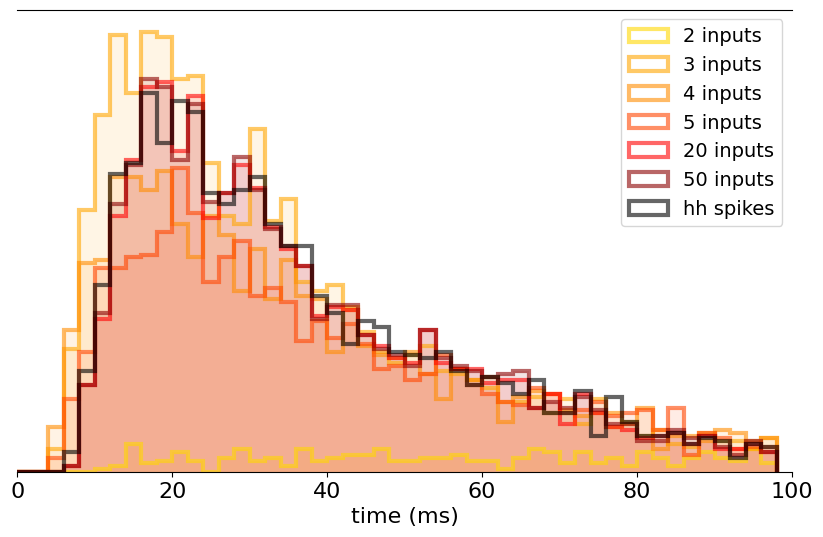

In [15]:
compare_ISIs(
    nInputs_results['wb_os'], conductance_model_spikes['wb'],
    title='')

In [16]:
def compare_ISIs_KDE(eb_spikes, cond_spikes, n_to_plot = [3,4,5,10,20], title=None):
    fig, ax = plt.subplots(figsize=(10,6))

    colors = ['gold','orange','darkorange','orangered','red','darkred','brown']
    alpha=0.6
    X_plot = np.linspace(0, 100, 1000)[:, np.newaxis]
    
    for i, n in enumerate(n_to_plot):
        train = eb_spikes[n]
        isis = np.array([train[i] - train[i-1] for i in range(1,len(train))]).reshape(-1,1)
        kde = KernelDensity(kernel='gaussian', bandwidth=5).fit(isis)
        log_dens = kde.score_samples(X_plot)
        ax.plot(X_plot, np.exp(log_dens), color=colors[i])
    
    hh_isis = np.array([cond_spikes[i] - cond_spikes[i-1] for i in range(1,len(cond_spikes))]).reshape(-1,1)
    hh_kde = KernelDensity(kernel='gaussian', bandwidth=5).fit(hh_isis)
    hh_log_dens = hh_kde.score_samples(X_plot)
    ax.plot(X_plot, np.exp(hh_log_dens), color='black', linestyle='dashed')

    ax.legend([f'{n} inputs' for n in n_to_plot] + ['full history'], fontsize=14)
    ax.set_xlabel('time (ms)', fontsize=16)
    xticks = range(0,101,20)
    ax.set_xticks(xticks)
    ax.set_yticks([])
    ax.set_xticklabels(xticks, fontsize=16)
    ax.set_xlim(0,100)

    #ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    
    if title:
        ax.set_title(title, fontsize=16)
    plt.show()

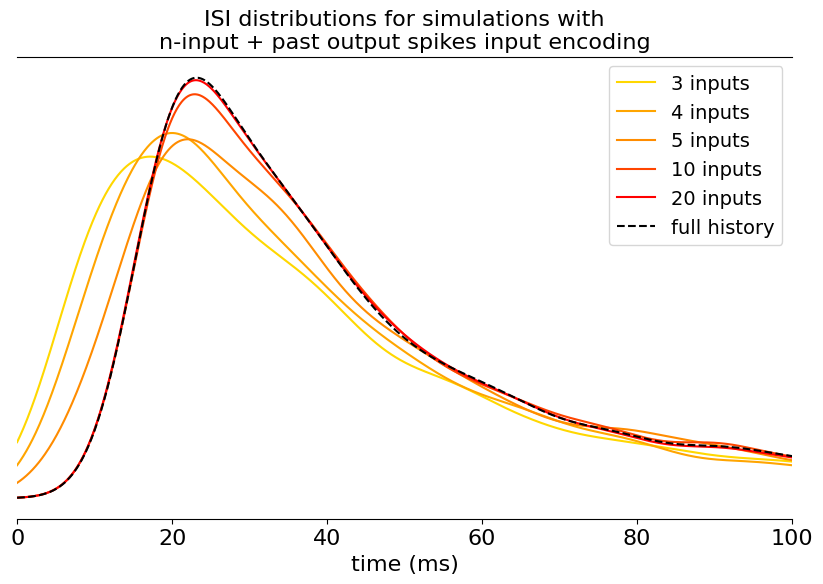

In [17]:
compare_ISIs_KDE(
    nInputs_results['base_os'], conductance_model_spikes['base'], n_to_plot = [3,4,5,10,20],
    title='ISI distributions for simulations with\nn-input + past output spikes input encoding')

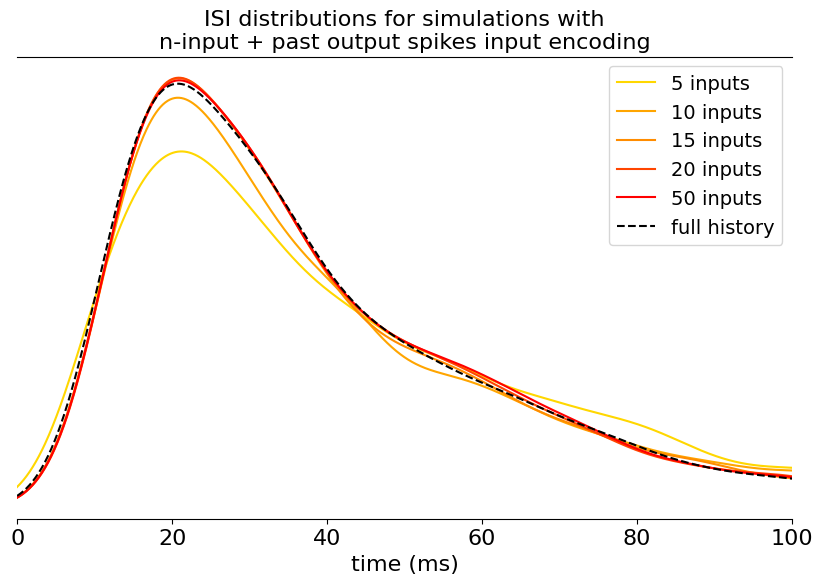

In [18]:
compare_ISIs_KDE(
    nInputs_results['wb_os'], conductance_model_spikes['wb'], n_to_plot = [5,10,15,20,50],
    title='ISI distributions for simulations with\nn-input + past output spikes input encoding')

In [19]:
model_types = ['base', 'lw', 'lt',  'lwlt', 'burst', 'wb']
modeltype2color = {
    'base':'maroon',
    'lw':'orangered',
    'lt':'darkgreen',
    'lwlt':'teal',
    'burst':'indigo',
    'wb':'black'
}

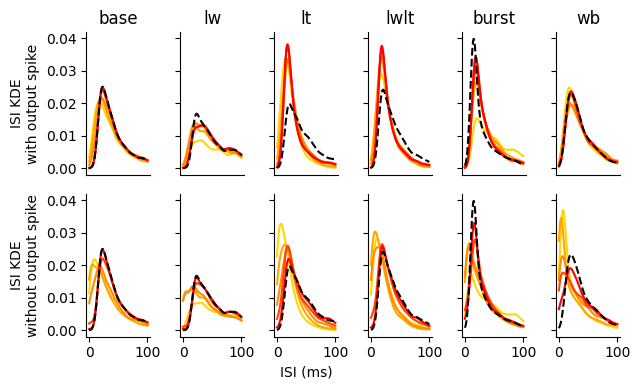

In [36]:
x_max = 100

# models to plot specifics
n_to_plot = [3,4,5,10,20]

# KDE specifics
X_plot = np.linspace(0, x_max, 1000)[:, np.newaxis]

# figure specifics
fig, axes = plt.subplots(2,6, figsize=(6.5,4), sharey=True)

colors = ['gold','orange','darkorange','orangered','red','darkred','brown']

for ax_x, model_type in enumerate(model_types):
    
    for i, n in enumerate(n_to_plot):
        # with output spike
        train = nInputs_results[model_type+'_os'][n]
        isis = np.array([train[i] - train[i-1] for i in range(1,len(train))]).reshape(-1,1)
        kde = KernelDensity(kernel='gaussian', bandwidth=5).fit(isis)
        log_dens = kde.score_samples(X_plot)
        axes[0, ax_x].plot(X_plot, np.exp(log_dens), color=colors[i])
        
        # without output spike
        train = nInputs_results[model_type+'_nos'][n]
        isis = np.array([train[i] - train[i-1] for i in range(1,len(train))]).reshape(-1,1)
        kde = KernelDensity(kernel='gaussian', bandwidth=5).fit(isis)
        log_dens = kde.score_samples(X_plot)
        axes[1, ax_x].plot(X_plot, np.exp(log_dens), color=colors[i])

    # ground truth
    hh_train = conductance_model_spikes[model_type]
    hh_isis = np.array([hh_train[i] - hh_train[i-1] for i in range(1,len(hh_train))]).reshape(-1,1)
    hh_kde = KernelDensity(kernel='gaussian', bandwidth=5).fit(hh_isis)
    hh_log_dens = hh_kde.score_samples(X_plot)
    axes[0, ax_x].plot(X_plot, np.exp(hh_log_dens), color='black', linestyle='dashed')
    axes[1, ax_x].plot(X_plot, np.exp(hh_log_dens), color='black', linestyle='dashed')
    
    # plot aesthetics
    axes[0, ax_x].spines['right'].set_visible(False)
    axes[0, ax_x].spines['top'].set_visible(False)
    axes[1, ax_x].spines['right'].set_visible(False)
    axes[1, ax_x].spines['top'].set_visible(False)
    
    axes[0, ax_x].set_xticks([])
    axes[0, ax_x].set_title(model_type)
    
axes[0,0].set_ylabel('ISI KDE\nwith output spike')
axes[1,0].set_ylabel('ISI KDE\nwithout output spike')
axes[1,2].set_xlabel('ISI (ms)')

plt.tight_layout()

savefig = True
if savefig: 
    plt.savefig(f'{figures_dir}nInputs_point_cell_ISI_dists.svg', format='svg')
    plt.savefig(f'{figures_dir}nInputs_point_cell_ISI_dists.png', format='png', dpi=300)

plt.show()

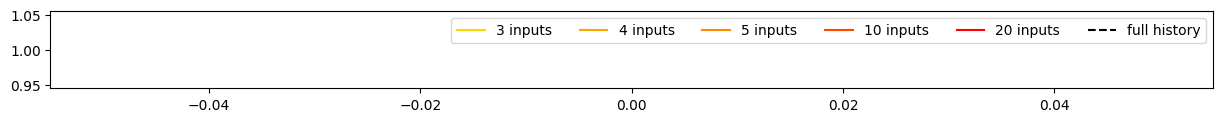

In [38]:
savefig = False

figures_dir = '../figures/'
fig = plt.figure(figsize = (15,1))
ax = fig.add_subplot(111, )

n_to_plot = [3,4,5,10,20]
colors = ['gold','orange','darkorange','orangered','red','darkred','brown']
# figure specifics

for i, n in enumerate(n_to_plot):
    ax.plot([0,0],[1,1], color=colors[i])

ax.plot([0,0],[1,1], color='black', linestyle='dashed')

plt.legend(['3 inputs','4 inputs','5 inputs','10 inputs','20 inputs','full history'], ncol=6)

savefig = True
if savefig:
    plt.savefig(f'{figures_dir}nInputs_point_cell_ISI_legend.svg', format='svg')
else:
    plt.show()

## Spike train comparison metrics

In [22]:
# parameterizations for the distance metrics
q = 1.0 / (10.0 * ms) # cost factor for shifting spikes in the victor purpura distance
tau = 10.0 * ms # time constant for the van rossum distance

In [23]:
sim_duration = 100000

In [24]:
nInputs_trains = {
    'base_os':{},
    'lw_os':{},
    'lt_os':{},
    'lwlt_os':{},
    'burst_os':{},
    'wb_os':{},
    'base_nos':{},
    'lw_nos':{},
    'lt_nos':{},
    'lwlt_nos':{},
    'burst_nos':{},
    'wb_nos':{},
}

In [25]:
conductance_trains = {
    'base':None,
    'lw':None,
    'lt':None,
    'lwlt':None,
    'burst':None,
    'wb':None
}

In [26]:
for model_type in nInputs_results:
    base_model_type = model_type.split('_')[0]
    conductance_trains[base_model_type] = neo.SpikeTrain(
        conductance_model_spikes[base_model_type] * ms, t_stop=sim_duration*ms)
    for n in ns:
        nInputs_trains[model_type][n] = neo.SpikeTrain(nInputs_results[model_type][n] * ms, t_stop=sim_duration*ms)

In [27]:
vp_dists = {
    'base_os':{},
    'lw_os':{},
    'lt_os':{},
    'lwlt_os':{},
    'burst_os':{},
    'wb_os':{},
    'base_nos':{},
    'lw_nos':{},
    'lt_nos':{},
    'lwlt_nos':{},
    'burst_nos':{},
    'wb_nos':{},
}
vr_dists = {
    'base_os':{},
    'lw_os':{},
    'lt_os':{},
    'lwlt_os':{},
    'burst_os':{},
    'wb_os':{},
    'base_nos':{},
    'lw_nos':{},
    'lt_nos':{},
    'lwlt_nos':{},
    'burst_nos':{},
    'wb_nos':{},
}

for model_type in nInputs_results:
    base_model_type = model_type.split('_')[0]
    for n in ns:
        vp_dists[model_type][n] = victor_purpura_distance(
            [conductance_trains[base_model_type], nInputs_trains[model_type][n]], q)[0, 1]
        vr_dists[model_type][n] = van_rossum_distance(
            [conductance_trains[base_model_type], nInputs_trains[model_type][n]], tau)[0, 1]

In [28]:
model_types = ['base', 'lw', 'lt',  'lwlt', 'burst', 'wb']
modeltype2color = {
    'base':'maroon',
    'lw':'orangered',
    'lt':'darkgreen',
    'lwlt':'teal',
    'burst':'indigo',
    'wb':'black'
}

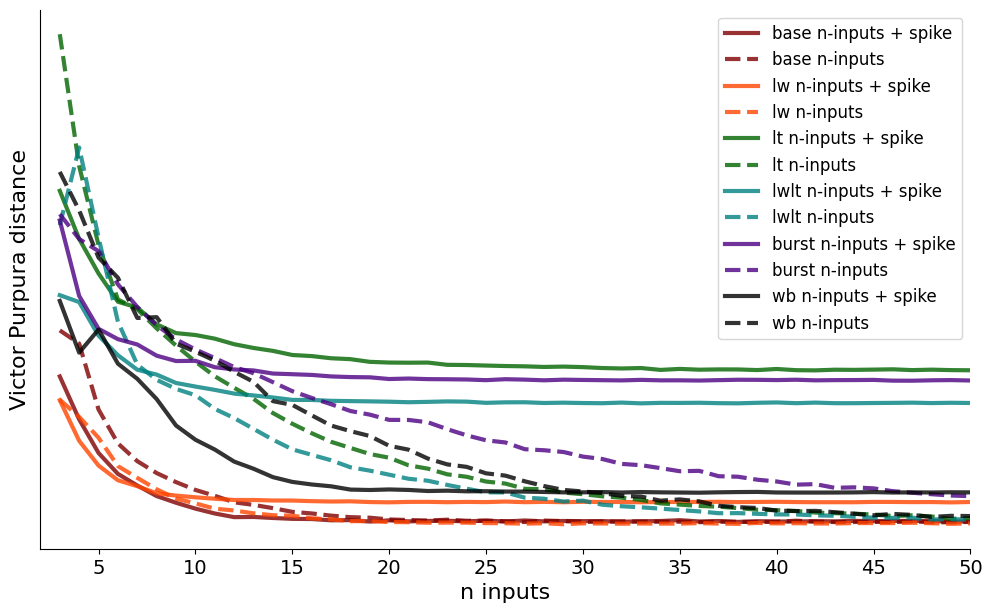

In [29]:
fig, ax = plt.subplots(1, figsize=(12,7))
legend_labels = []
for i, model_type in enumerate(model_types):
    ax.plot(ns, vp_dists[model_type+'_os'].values(), c=modeltype2color[model_type], linewidth=3, alpha=0.8)
    ax.plot(ns, vp_dists[model_type+'_nos'].values(), '--', 
             c=modeltype2color[model_type], linewidth=3, alpha=0.8)
    legend_labels.append(model_type + ' n-inputs + spike')
    legend_labels.append(model_type + ' n-inputs')
    
ax.set_xlim(2, 50)  
ax.set_ylabel('Victor Purpura distance', fontsize=16)
ax.set_xlabel('n inputs', fontsize=16)

ax.set_xticks(np.arange(5,51,5))
ax.set_xticklabels(np.arange(5,51,5), fontsize=14)

ax.set_yticks([])

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.legend(legend_labels, fontsize=12)
plt.show()

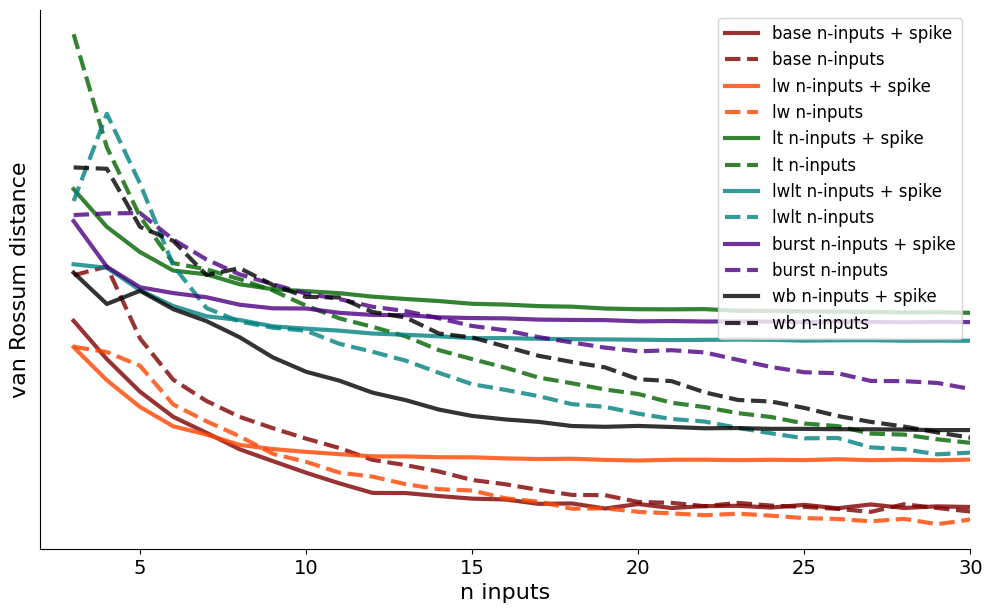

In [30]:
fig, ax = plt.subplots(1, figsize=(12,7))
legend_labels = []
for i, model_type in enumerate(model_types):
    ax.plot(ns, vr_dists[model_type+'_os'].values(), c=modeltype2color[model_type], linewidth=3, alpha=0.8)
    ax.plot(ns, vr_dists[model_type+'_nos'].values(), '--', 
             c=modeltype2color[model_type], linewidth=3, alpha=0.8)
    legend_labels.append(model_type + ' n-inputs + spike')
    legend_labels.append(model_type + ' n-inputs')
    
ax.set_xlim(2, 30)  
plt.ylabel('van Rossum distance', fontsize=16)
ax.set_xlabel('n inputs', fontsize=16)

ax.set_xticks(np.arange(5,31,5))
ax.set_xticklabels(np.arange(5,31,5), fontsize=14)

ax.set_yticks([])

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.legend(legend_labels, fontsize=12)
plt.show()

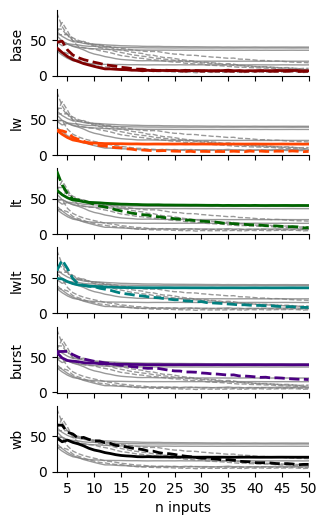

In [41]:
fig, axes = plt.subplots(6, 1, figsize=(3.25,6), sharex=True)
legend_labels = []
for i, model_type in enumerate(model_types):
    for j in range(6):
        if j != i:
            axes[j].plot(
                ns, vr_dists[model_type+'_os'].values(), 
                c='grey', linewidth=1, alpha=0.8
            )
            axes[j].plot(
                ns, vr_dists[model_type+'_nos'].values(), '--', 
                c='grey', linewidth=1, alpha=0.8
            )
    
    axes[i].plot(
        ns, vr_dists[model_type+'_os'].values(), 
        c=modeltype2color[model_type], linewidth=2, alpha=1, zorder=100
    )
    axes[i].plot(
        ns, vr_dists[model_type+'_nos'].values(), '--', 
        c=modeltype2color[model_type], linewidth=2, alpha=1, zorder=100
    )
    axes[i].set_ylabel(model_type)
    
    axes[i].spines['top'].set_visible(False)
    axes[i].spines['right'].set_visible(False)
    
    legend_labels.append(model_type + ' n-inputs + spike')
    legend_labels.append(model_type + ' n-inputs')
    
axes[0].set_xlim(3, 50)  
axes[-1].set_xlabel('n inputs')

axes[0].set_xticks(np.arange(5,51,5))
axes[0].set_xticklabels(np.arange(5,51,5))

ax.legend(legend_labels)

savefig=False
if savefig:
    plt.savefig(f'{figures_dir}nInputs_point_cell_vr_dists.svg', format='svg')
    plt.savefig(f'{figures_dir}nInputs_point_cell_vr_dists.png', format='png', dpi=300)

plt.show()

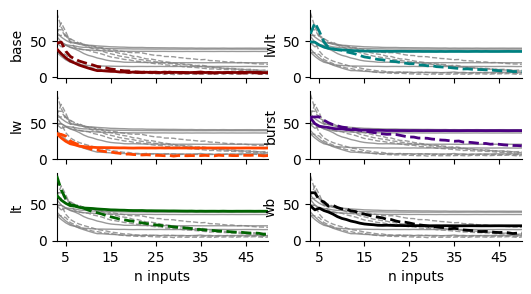

In [64]:
fig, axes = plt.subplots(3, 2, figsize=(6,3), sharex=True)
legend_labels = []
for i, model_type in enumerate(model_types):
    for j in range(6):
        if j != i:
            axes[j%3, math.floor(j/3)].plot(
                ns, vr_dists[model_type+'_os'].values(), 
                c='grey', linewidth=1, alpha=0.8
            )
            axes[j%3, math.floor(j/3)].plot(
                ns, vr_dists[model_type+'_nos'].values(), '--', 
                c='grey', linewidth=1, alpha=0.8
            )
    
    axes[i%3, math.floor(i/3)].plot(
        ns, vr_dists[model_type+'_os'].values(), 
        c=modeltype2color[model_type], linewidth=2, alpha=1, zorder=100
    )
    axes[i%3, math.floor(i/3)].plot(
        ns, vr_dists[model_type+'_nos'].values(), '--', 
        c=modeltype2color[model_type], linewidth=2, alpha=1, zorder=100
    )
    axes[i%3, math.floor(i/3)].set_ylabel(model_type)
    
    axes[i%3, math.floor(i/3)].spines['top'].set_visible(False)
    axes[i%3, math.floor(i/3)].spines['right'].set_visible(False)
    
    legend_labels.append(model_type + ' n-inputs + spike')
    legend_labels.append(model_type + ' n-inputs')
    
axes[0,0].set_xlim(3, 50)  
axes[-1,0].set_xlabel('n inputs')
axes[-1,-1].set_xlabel('n inputs')

axes[0,-1].set_xticks(np.arange(5,51,10))
axes[0,-1].set_xticklabels(np.arange(5,51,10))

ax.legend(legend_labels)

savefig=True
if savefig:
    plt.savefig(f'{figures_dir}nInputs_point_cell_vr_dists.svg', format='svg')
    plt.savefig(f'{figures_dir}nInputs_point_cell_vr_dists.png', format='png', dpi=300)

plt.show()

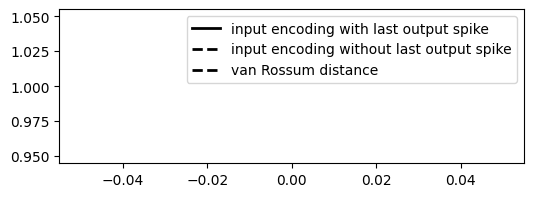

In [65]:
plt.figure(figsize=(6,2))
plt.plot([0,0], [1,1], color='black', linewidth=2)
plt.plot([0,0], [1,1], '--', color='black', linewidth=2)
plt.plot([0,0], [1,1], '--', color='black', linewidth=2)

plt.legend(['input encoding with last output spike',
            'input encoding without last output spike',
            'van Rossum distance'
           ])

savefig=True
if savefig:
    plt.savefig(f'{figures_dir}nInputs_point_cell_vr_dists_legend.svg', format='svg')
else:
    plt.show()